In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#lendo o dataset
df = pd.read_csv('data/stats.csv')

#define a ordem do dataset como sendo crescente de acordo com o ano
df = df.sort_values(by='Year')

#reseta os índices do dataset e deleta a coluna de índices antigos
df = df.reset_index(drop=True)

#deleta a segunda coluna
df = df.drop(df.columns[0], axis=1)

#deleta a coluna "Season", porque todas são iguais
df = df.drop('Season', axis=1)

#criando uma coluna de índice de país (com base na coluna "NOC")
df['NNOC'] = pd.Categorical(df['NOC'])
df['NNOC'] = df['NNOC'].cat.codes

df.head()

,Name,Sex,Age,Team,NOC,Games,Year,City,Sport,Event,Medal,NNOC
0,Paul Neumann (-Newman),M,20.0,Austria,AUT,1896 Summer,1896,Athina,Swimming,Swimming Men's 500 metres Freestyle,Gold,13
1,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Great Britain/Germany,GER,1896 Summer,1896,Athina,Tennis,Tennis Men's Doubles,Gold,80
2,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Germany,GER,1896 Summer,1896,Athina,Athletics,Athletics Men's 100 metres,NaN,80
3,"Friedrich Adolf ""Fritz"" Traun",M,20.0,Germany,GER,1896 Summer,1896,Athina,Athletics,Athletics Men's 800 metres,NaN,80
4,Efstathios Khorafas,M,NaN,Greece,GRE,1896 Summer,1896,Athina,Swimming,Swimming Men's 100 metres Freestyle,NaN,82


In [4]:
#mostrando uma tabela com a tradução de o que significa cada NNOC com base no NOC
NOC = df[['NOC', 'NNOC']]
NOC = NOC.drop_duplicates()
NOC = NOC.sort_values(by='NNOC')
NOC = NOC.reset_index(drop=True)
NOC.head()

,NOC,NNOC
0,AFG,0
1,AHO,1
2,ALB,2
3,ALG,3
4,AND,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237673 entries, 0 to 237672
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Name    237673 non-null  object 
 1   Sex     237673 non-null  object 
 2   Age     228484 non-null  float64
 3   Team    237673 non-null  object 
 4   NOC     237673 non-null  object 
 5   Games   237673 non-null  object 
 6   Year    237673 non-null  int64  
 7   City    237673 non-null  object 
 8   Sport   237673 non-null  object 
 9   Event   237673 non-null  object 
 10  Medal   36537 non-null   object 
 11  NNOC    237673 non-null  int16  
dtypes: float64(1), int16(1), int64(1), object(9)
memory usage: 20.4+ MB


In [6]:
import ipywidgets as widgets
from IPython.display import display

#criando um slider para selecionar o intervalo de anos
year_slider = widgets.IntRangeSlider(
    value=[1896, 2020],
    min=1896,
    max=2020,
    step=4,
    description='Intervalo de ano:',
    continuous_update=False
)

#criando um dropdown para selecionar a quantidade de países a serem mostrados
top_countries_dropdown = widgets.Dropdown(
    options=[5, 10, 15],
    value=10,
    description='Número de países:',
    disabled=False,
)

#criando a função que irá atualizar o gráfico de acordo com os valores selecionados
def update_plot(year_interval, top_countries):
    filtered_df1 = df[(df['Year'] >= year_interval[0]) & (df['Year'] <= year_interval[1])]
    filtered_df = filtered_df1.groupby('NOC')['Medal'].count().nlargest(top_countries)
    filtered_df = pd.DataFrame({'NOC': filtered_df.index, 'Medal': filtered_df.values})

    #adicionando no dataframe quantas das medalhas são de ouro, de prata e de bronze
    gold = []
    silver = []
    bronze = []
    for noc in filtered_df['NOC']:
        gold.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Gold')]))
        silver.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Silver')]))
        bronze.append(len(filtered_df1[(filtered_df1['NOC'] == noc) & (filtered_df1['Medal'] == 'Bronze')]))
    filtered_df['Gold'] = gold
    filtered_df['Silver'] = silver
    filtered_df['Bronze'] = bronze

    #define os dados que serão plotados
    medal_counts = filtered_df[['Gold', 'Silver', 'Bronze']]
    countries = filtered_df['NOC']

    #largura da barra
    bar_w = 0.7

    #posição da barra
    r = np.arange(len(countries))

    #criando a ordem de plotagem
    plt.figure(figsize=(14, 8))
    plt.barh(r, medal_counts['Bronze'], color='brown', height=bar_w, edgecolor='black', label='Bronze')
    plt.barh(r, medal_counts['Silver'], left=medal_counts['Bronze'], color='silver', height=bar_w, edgecolor='black', label='Silver')
    plt.barh(r, medal_counts['Gold'], left=medal_counts['Bronze'] + medal_counts['Silver'], color='gold', height=bar_w, edgecolor='black', label='Gold')

    #invertendo o eixo y (maior pro menor)
    plt.gca().invert_yaxis()

    #labels e título
    plt.xlabel('Número de Medalhas')
    plt.ylabel('Países')
    plt.yticks(r, countries)
    plt.title('Top ' + str(top_countries) + ' países com mais medalhas entre ' + str(year_interval[0]) + ' e ' + str(year_interval[1]))

    #definindo as coordenadas da tabela
    table_coords = [0.75, 0.3, 0.2, 0.4]

    #criando uma tabela
    table_data = [['País', 'Medalhas']] + [[country, medal_counts.loc[i].sum()] for i, country in enumerate(countries)]
    table = plt.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', bbox=table_coords)

    #formata a tabela
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)

    #plotando
    plt.legend(['Bronze', 'Prata', 'Ouro'])
    plt.show()

#criando o output
output = widgets.interactive_output(update_plot, {'year_interval': year_slider, 'top_countries': top_countries_dropdown})

#mostrando os widgets
display(year_slider, top_countries_dropdown, output)

IntRangeSlider(value=(1896, 2020), continuous_update=False, description='Intervalo de ano:', max=2020, min=189…

Dropdown(description='Número de países:', index=1, options=(5, 10, 15), value=10)

Output()

In [7]:
#dataframe pros EUA
df_USA = df[df['NOC'] == 'USA']

#contando cada tipo de medalha por ano
df_medalsUSA = df_USA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsUSA = df_medalsUSA[['Year', 'Bronze', 'Gold', 'Silver']]

#preenchendo os valores nulos com 0
df_medalsUSA.fillna(0, inplace=True)

#filtra os anos que não tem medalhas
athlete_count_per_yearUSA = df_USA.groupby('Year')['Name'].nunique().reset_index()

#merge
df_medalsUSA = pd.merge(df_medalsUSA, athlete_count_per_yearUSA, on='Year')

#renomeando a coluna
df_medalsUSA.rename(columns={'Name': 'Athlete Count'}, inplace=True)

df_medalsUSA['Athlete Count'] = df_medalsUSA['Athlete Count'].astype(int)

In [8]:
#dataframe para a Rússia
df_RUS = df[df['NOC'].isin(['RUS', 'EUN', 'URS', 'ROC'])]

#contando cada tipo de medalha por ano
df_medalsRUS = df_RUS.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsRUS.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsRUS.fillna(0, inplace=True)

#filtra o df por ano e conta o número total de atletas por ano
athlete_count_per_yearRUS = df_RUS.groupby('Year')['Name'].nunique().reset_index()

#merge dos df
df_medalsRUS = pd.merge(df_medalsRUS, athlete_count_per_yearRUS, on='Year')

#renomeia a coluna
df_medalsRUS.rename(columns={'Name': 'Athlete Count'}, inplace=True)

#transforma em inteiro
df_medalsRUS['Athlete Count'] = df_medalsRUS['Athlete Count'].astype(int)

df_medalsRUS.head()

,Year,Bronze,Gold,Silver,Athlete Count
0,1908,0.0,1.0,2.0,6
1,1912,9.0,0.0,5.0,159
2,1952,19.0,36.0,62.0,295
3,1956,55.0,68.0,46.0,281
4,1960,45.0,61.0,63.0,283


In [9]:
#dataframe para a China
df_CHN = df[df['NOC'] == 'CHN']

#contando cada tipo de medalha por ano
df_medalsCHN = df_CHN.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsCHN.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsCHN.fillna(0, inplace=True)

#filtra o df por ano e conta o número total de atletas por ano
athlete_count_per_yearCHN = df_CHN.groupby('Year')['Name'].nunique().reset_index()

#merge dos df
df_medalsCHN = pd.merge(df_medalsCHN, athlete_count_per_yearCHN, on='Year')

#renomeia a coluna
df_medalsCHN.rename(columns={'Name': 'Athlete Count'}, inplace=True)

#transforma em inteiro
df_medalsCHN['Athlete Count'] = df_medalsCHN['Athlete Count'].astype(int)

df_medalsCHN.head()

,Year,Bronze,Gold,Silver,Athlete Count
0,1984,37,24,13,215
1,1988,30,6,16,271
2,1992,19,18,45,243
3,1996,17,19,70,289
4,2000,17,39,23,266


In [10]:
#dataframe para a França
df_FRA = df[df['NOC'] == 'FRA']

#contando cada tipo de medalha por ano
df_medalsFRA = df_FRA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsFRA.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsFRA.fillna(0, inplace=True)

#filtra o df por ano e conta o número total de atletas por ano
athlete_count_per_yearFRA = df_FRA.groupby('Year')['Name'].nunique().reset_index()

#merge dos df
df_medalsFRA = pd.merge(df_medalsFRA, athlete_count_per_yearFRA, on='Year')

#renomeia a coluna
df_medalsFRA.rename(columns={'Name': 'Athlete Count'}, inplace=True)

#transforma em inteiro
df_medalsFRA['Athlete Count'] = df_medalsFRA['Athlete Count'].astype(int)

df_medalsFRA.head()

,Year,Bronze,Gold,Silver,Athlete Count
0,1896,2.0,5.0,4.0,12
1,1900,82.0,52.0,101.0,716
2,1904,0.0,0.0,2.0,1
3,1906,28.0,20.0,16.0,56
4,1908,23.0,12.0,5.0,208


In [11]:
#dataframe para o Reino Unido
df_GBR = df[df['NOC'] == 'GBR']

#contando cada tipo de medalha por ano
df_medalsGBR = df_GBR.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsGBR.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsGBR.fillna(0, inplace=True)

#filtra o df por ano e conta o número total de atletas por ano
athlete_count_per_yearGBR = df_GBR.groupby('Year')['Name'].nunique().reset_index()

#merge dos df
df_medalsGBR = pd.merge(df_medalsGBR, athlete_count_per_yearGBR, on='Year')

#renomeia a coluna
df_medalsGBR.rename(columns={'Name': 'Athlete Count'}, inplace=True)

#transforma em inteiro
df_medalsGBR['Athlete Count'] = df_medalsGBR['Athlete Count'].astype(int)

df_medalsGBR.head()

,Year,Bronze,Gold,Silver,Athlete Count
0,1896,3.0,3.0,3.0,10
1,1900,15.0,59.0,34.0,104
2,1904,0.0,1.0,1.0,6
3,1906,8.0,9.0,22.0,48
4,1908,90.0,147.0,131.0,735


In [12]:
#dataframe para o Brasil
df_BRA = df[df['NOC'] == 'BRA']

#contando cada tipo de medalha por ano
df_medalsBRA = df_BRA.groupby('Year')['Medal'].value_counts().unstack().reset_index()

#renomeando as colunas
df_medalsBRA.columns = ['Year', 'Bronze', 'Gold', 'Silver']

#preenchendo os valores nulos com 0
df_medalsBRA.fillna(0, inplace=True)

#filtra o df por ano e conta o número total de atletas por ano
athlete_count_per_yearBRA = df_BRA.groupby('Year')['Name'].nunique().reset_index()

#merge dos df
df_medalsBRA = pd.merge(df_medalsBRA, athlete_count_per_yearBRA, on='Year')

#renomeia a coluna
df_medalsBRA.rename(columns={'Name': 'Athlete Count'}, inplace=True)

#transforma em inteiro
df_medalsBRA['Athlete Count'] = df_medalsBRA['Athlete Count'].astype(int)

df_medalsBRA.head()

,Year,Bronze,Gold,Silver,Athlete Count
0,1920,5.0,1.0,1.0,19
1,1948,10.0,0.0,0.0,70
2,1952,2.0,1.0,0.0,97
3,1956,0.0,1.0,0.0,47
4,1960,13.0,0.0,0.0,72


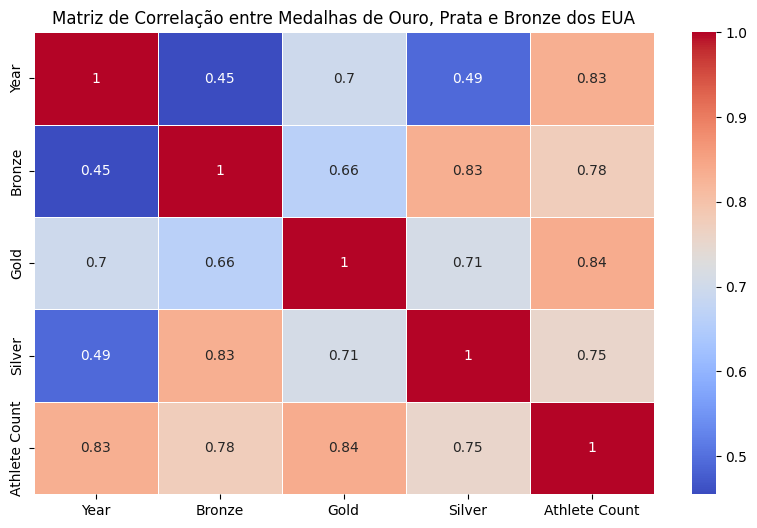

In [13]:
#montando a matriz de correlação dos EUA somente para mostrar que há correlação entre as variáveis
correlation = df_medalsUSA.corr()

#plotando a matriz de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação entre Medalhas de Ouro, Prata e Bronze dos EUA')
plt.show()

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error

2024-03-22 18:29:44.055333: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 18:29:44.059048: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 18:29:44.089316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 18:29:45.021315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
#utilizando LSTM para prever a quantidade de medalhas dos EUA com base na quantidade de atletas e nas medalhas dos anos anteriores

#normalizando
scaler = MinMaxScaler(feature_range=(0, 1))

#normalizando os dados
df_trainUSA_values = df_medalsUSA[['Gold', 'Silver', 'Bronze', 'Athlete Count']].values
df_trainUSA_scaled = scaler.fit_transform(df_trainUSA_values)

#treinando 70%:
train_size = int(len(df_trainUSA_scaled) * 0.7)
test_size = len(df_trainUSA_scaled) - train_size
train, test = df_trainUSA_scaled[0:train_size, :], df_trainUSA_scaled[train_size:len(df_trainUSA_scaled), :]

look_back = 1

#criando os datasets de treino e teste
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

#definindo o modelo
model = Sequential()
model.add(LSTM(372, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(trainY.shape[1]))

#compilando o modelo
model.compile(loss='mean_squared_error', optimizer='adam')

#fit
model.fit(trainX, trainY, epochs=41, batch_size=18, verbose=0)

#prevendo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#denormalizando
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

#calculando o RMSE
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Train Score: 80.11 RMSE
Test Score: 77.54 RMSE


In [16]:
#shift dos valores para plotar
trainPredictPlot = np.empty_like(df_trainUSA_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

testPredictPlot = np.empty_like(df_trainUSA_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(df_trainUSA_scaled) - 1, :] = testPredict

trainPredictPlot = trainPredictPlot[:, :-1]
testPredictPlot = testPredictPlot[:, :-1]

#cria um novo dataframe com os dados previstos
df_predictedUSA = df_medalsUSA.copy()

#removendo a coluna de atletas
df_predictedUSA = df_predictedUSA.drop('Athlete Count', axis=1)

#transformando Year em index
df_predictedUSA.set_index('Year', inplace=True)

#transforma trainPredictPlot num dataset
trainPredictPlot_df = pd.DataFrame(trainPredictPlot)

#renomeando as colunas
trainPredictPlot_df.columns = ['Gold', 'Silver', 'Bronze']

#adicionando os anos
trainPredictPlot_df['Year'] = df_medalsUSA['Year']

#transformando Year em index
trainPredictPlot_df.set_index('Year', inplace=True)

#transforma testPredictPlot num dataset
testPredictPlot_df = pd.DataFrame(testPredictPlot)

#renomeando as colunas
testPredictPlot_df.columns = ['Gold', 'Silver', 'Bronze']

#adicionando os anos
testPredictPlot_df['Year'] = df_medalsUSA['Year']

#transformando Year em index
testPredictPlot_df.set_index('Year', inplace=True)

#shiftando os valores para plotar
trainPredictPlot_df = trainPredictPlot_df.shift(-1)
testPredictPlot_df = testPredictPlot_df.shift(-1)

#removendo todos os valores nulos
testPredictPlot_df = testPredictPlot_df.dropna()
trainPredictPlot_df = trainPredictPlot_df.dropna()

#arredondando todos os valores para cima
testPredictPlot_df = testPredictPlot_df.apply(np.ceil)
trainPredictPlot_df = trainPredictPlot_df.apply(np.ceil)

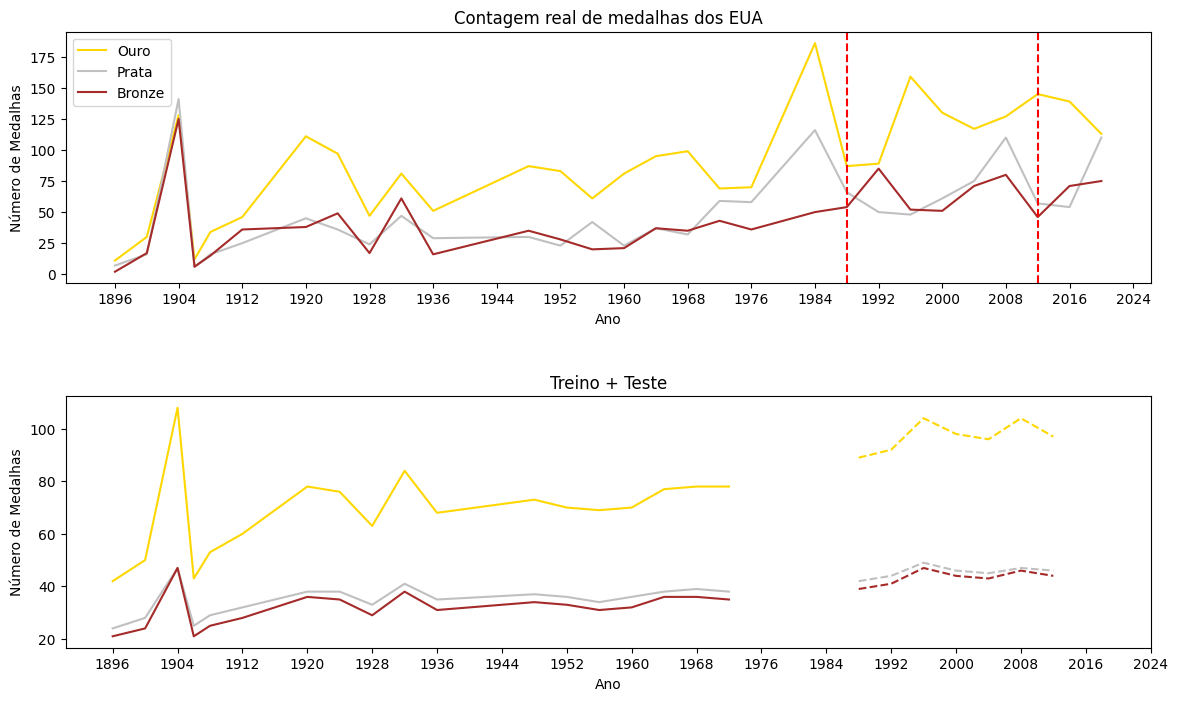

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

df_trainUSAp = df_medalsUSA.copy()

#removendo a coluna de atletas
df_trainUSAp = df_trainUSAp.drop('Athlete Count', axis=1)

#transformando Year em index
df_trainUSAp.set_index('Year', inplace=True)

#plot dos dados originais
ax1.plot(df_trainUSAp['Gold'], color='gold')
ax1.plot(df_trainUSAp['Silver'], color='silver')
ax1.plot(df_trainUSAp['Bronze'], color='brown')
ax1.set_title('Contagem real de medalhas dos EUA')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Medalhas')
ax1.legend(['Ouro', 'Prata', 'Bronze'])
ax1.set_xticks(range(1896, 2025, 8))
ax1.axvline(x=1988, color='red', linestyle='--')
ax1.axvline(x=2012, color='red', linestyle='--')

#plota o treino e o teste
ax2.plot(trainPredictPlot_df['Gold'], color='gold')
ax2.plot(trainPredictPlot_df['Silver'], color='silver')
ax2.plot(trainPredictPlot_df['Bronze'], color='brown')
ax2.plot(testPredictPlot_df['Gold'], color='gold', linestyle='dashed')
ax2.plot(testPredictPlot_df['Silver'], color='silver', linestyle='dashed')
ax2.plot(testPredictPlot_df['Bronze'], color='brown', linestyle='dashed')
ax2.set_title('Treino + Teste')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Medalhas')
ax2.set_xticks(range(1896, 2025, 8))

plt.subplots_adjust(hspace=0.45)

plt.show()

In [18]:
#define o número de previsões
num_predictions = 3

#cria um array para armazenar as previsões futuras
future_predictions = []

#pega a última sequência
last_sequence = testX[-1]

#reshape da última sequência
last_sequence = np.reshape(last_sequence, (1, last_sequence.shape[0], last_sequence.shape[1]))

#gera as previsões futuras
for _ in range(num_predictions):
    next_prediction = model.predict(last_sequence, verbose=0)
    
    future_predictions.append(next_prediction[0])
    
    #atualiza a última sequência
    last_sequence = np.append(last_sequence[:, :, :], [[next_prediction[0]]], axis=1)

#denormalize
future_predictions = scaler.inverse_transform(future_predictions)

future_predictions = future_predictions[:, :-1]

print("Future Predictions:")
for i, prediction in enumerate(future_predictions):
    print(f"Prediction {i+1}: {prediction}")

Future Predictions:
Prediction 1: [96.18527746 45.18640181 43.15575621]
Prediction 2: [140.13157493  65.27860022  64.91105437]
Prediction 3: [193.15877116  87.8204695   89.6600337 ]


In [19]:
#adiciionando a previsão de 2024 no df
ano_futuro = [2016, 2020, 2024]
future_predictions_df = pd.DataFrame(future_predictions[2:], columns=['Gold', 'Silver', 'Bronze'], index=ano_futuro[2:])

#combina o future_predictions_df com o df_predictedUSA
df_predictedUSA = pd.concat([df_predictedUSA, future_predictions_df])

#remove indices duplicados
df_predictedUSA = df_predictedUSA[~df_predictedUSA.index.duplicated(keep='last')]

#arredonda e transforma em inteiro
df_predictedUSA = df_predictedUSA.apply(np.ceil).astype(int)

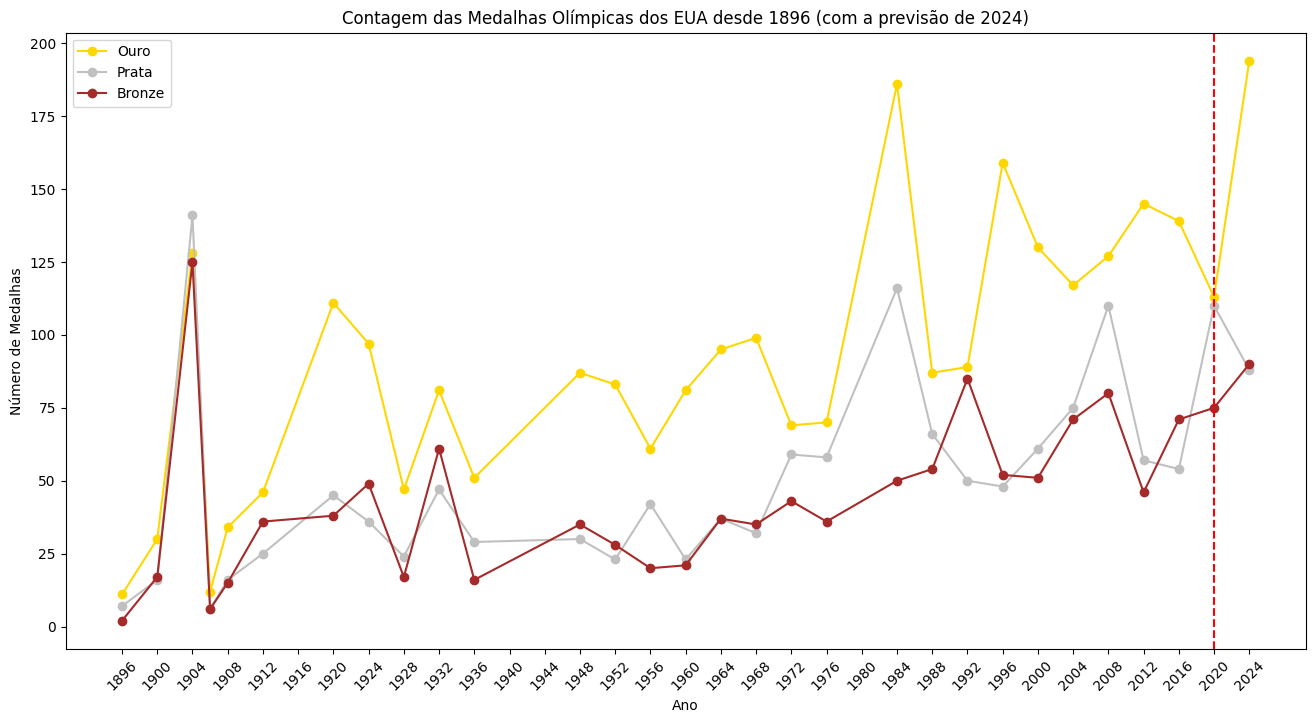

In [20]:
#definindo o tamanho
plt.figure(figsize=(16, 8))

#plotando cada linha
plt.plot(df_predictedUSA['Gold'], label='Gold', color='gold', marker='o')
plt.plot(df_predictedUSA['Silver'], label='Silver', color='silver', marker='o')
plt.plot(df_predictedUSA['Bronze'], label='Bronze', color='brown', marker='o')

#labels e títulos
plt.title('Contagem das Medalhas Olímpicas dos EUA desde 1896 (com a previsão de 2024)')
plt.xlabel('Ano')
plt.ylabel('Número de Medalhas')
plt.legend(['Ouro', 'Prata', 'Bronze'])

#ticks
plt.xticks(range(1896, 2025, 4))
plt.tick_params(axis='x', rotation=45)

#linha vertical
plt.axvline(x=2020, color='red', linestyle='--')

plt.show()

In [21]:
#utilizando LSTM para prever a quantidade de medalhas do Braisl (BRA) com base na quantidade de atletas e nas medalhas dos anos anteriores

#normalizando os dados
df_trainBRA_values = df_medalsBRA[['Gold', 'Silver', 'Bronze', 'Athlete Count']].values
df_trainBRA_scaled = scaler.fit_transform(df_trainBRA_values)

#treinando 70%:
train_sizeBRA = int(len(df_trainBRA_scaled) * 0.7)
test_sizeBRA = len(df_trainBRA_scaled) - train_sizeBRA
trainBRA, testBRA = df_trainBRA_scaled[0:train_sizeBRA, :], df_trainBRA_scaled[train_sizeBRA:len(df_trainBRA_scaled), :]

look_back = 1

trainXBRA, trainYBRA = create_dataset(trainBRA, look_back)
testXBRA, testYBRA = create_dataset(testBRA, look_back)

trainXBRA = np.reshape(trainXBRA, (trainXBRA.shape[0], trainXBRA.shape[1], trainXBRA.shape[2]))
testXBRA = np.reshape(testXBRA, (testXBRA.shape[0], testXBRA.shape[1], testXBRA.shape[2]))

#definindo o modelo
modelBRA = Sequential()
modelBRA.add(LSTM(450, input_shape=(trainXBRA.shape[1], trainXBRA.shape[2])))
modelBRA.add(Dense(trainYBRA.shape[1]))

#compilando o modelo
modelBRA.compile(loss='mean_squared_error', optimizer='adam')

#fit
modelBRA.fit(trainXBRA, trainYBRA, epochs=131, batch_size=37, verbose=0)

#prevendo
trainPredictBRA = modelBRA.predict(trainXBRA)
testPredictBRA = modelBRA.predict(testXBRA)

#denormalizando
trainPredictBRA = np.clip(scaler.inverse_transform(trainPredictBRA), 0, None)
trainYBRA = np.clip(scaler.inverse_transform(trainYBRA), 0, None)
testPredictBRA = np.clip(scaler.inverse_transform(testPredictBRA), 0, None)
testYBRA = np.clip(scaler.inverse_transform(testYBRA), 0, None)

#calculando o RMSE
trainScoreBRA = np.sqrt(mean_squared_error(trainYBRA, trainPredictBRA))
print('Train Score: %.2f RMSE' % (trainScoreBRA))
testScoreBRA = np.sqrt(mean_squared_error(testYBRA, testPredictBRA))
print('Test Score: %.2f RMSE' % (testScoreBRA))

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Train Score: 11.72 RMSE
Test Score: 50.02 RMSE


In [22]:
#shift dos valores para plotar
trainPredictPlotBRA = np.empty_like(df_trainBRA_scaled)
trainPredictPlotBRA[:, :] = np.nan
trainPredictPlotBRA[look_back:len(trainPredictBRA) + look_back, :] = trainPredictBRA

testPredictPlotBRA = np.empty_like(df_trainBRA_scaled)
testPredictPlotBRA[:, :] = np.nan
testPredictPlotBRA[len(trainPredictBRA) + (look_back * 2) + 1:len(df_trainBRA_scaled) - 1, :] = testPredictBRA

trainPredictPlotBRA = trainPredictPlotBRA[:, :-1]
testPredictPlotBRA = testPredictPlotBRA[:, :-1]

#cria um novo dataframe com os dados previstos
df_predictedBRA = df_medalsBRA.copy()

#removendo a coluna de atletas
df_predictedBRA = df_predictedBRA.drop('Athlete Count', axis=1)

#transformando Year em index
df_predictedBRA.set_index('Year', inplace=True)

#transforma trainPredictPlot num dataset
trainPredictPlot_dfBRA = pd.DataFrame(trainPredictPlotBRA)

#renomeando as colunas
trainPredictPlot_dfBRA.columns = ['Gold', 'Silver', 'Bronze']

#adicionando os anos
trainPredictPlot_dfBRA['Year'] = df_medalsBRA['Year']

#transformando Year em index
trainPredictPlot_dfBRA.set_index('Year', inplace=True)

#transforma testPredictPlot num dataset
testPredictPlot_dfBRA = pd.DataFrame(testPredictPlotBRA)

#renomeando as colunas
testPredictPlot_dfBRA.columns = ['Gold', 'Silver', 'Bronze']

#adicionando os anos
testPredictPlot_dfBRA['Year'] = df_medalsBRA['Year']

#transformando Year em index
testPredictPlot_dfBRA.set_index('Year', inplace=True)

#shiftando os valores para plotar
trainPredictPlot_dfBRA = trainPredictPlot_dfBRA.shift(-1)
testPredictPlot_dfBRA = testPredictPlot_dfBRA.shift(-1)

#removendo todos os valores nulos
testPredictPlot_dfBRA = testPredictPlot_dfBRA.dropna()
trainPredictPlot_dfBRA = trainPredictPlot_dfBRA.dropna()

#arredondando todos os valores para cima
testPredictPlot_dfBRA = testPredictPlot_dfBRA.apply(np.ceil)
trainPredictPlot_dfBRA = trainPredictPlot_dfBRA.apply(np.ceil)

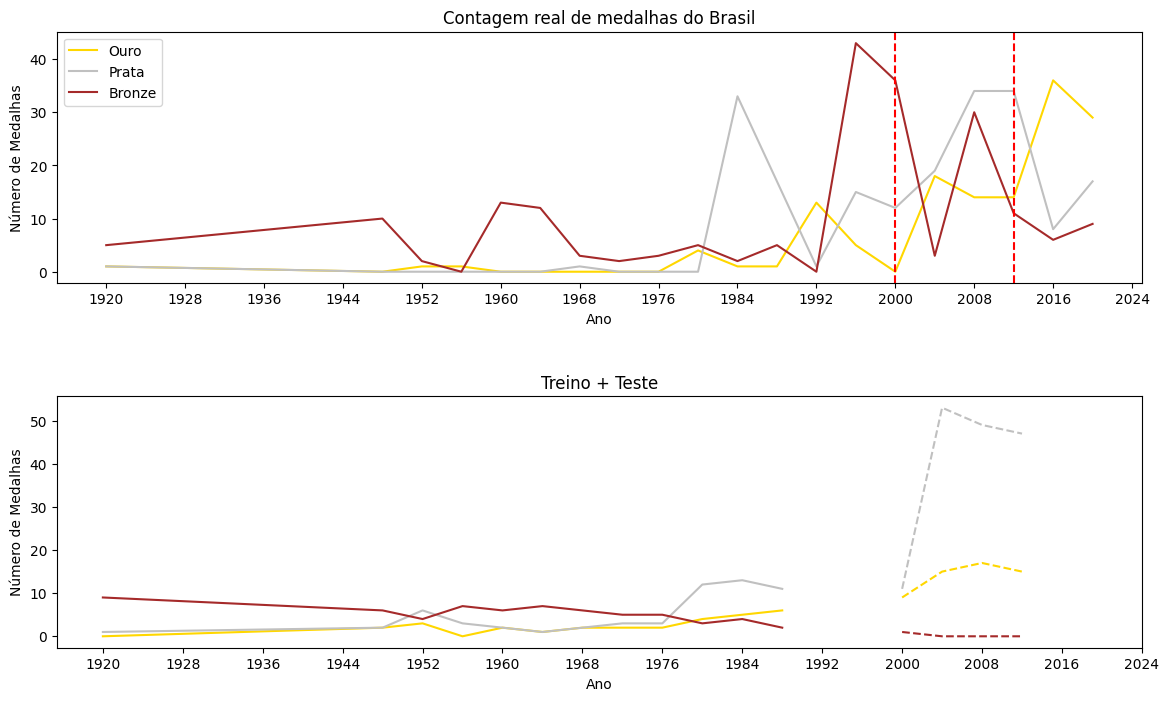

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

df_trainBRAp = df_medalsBRA.copy()

#removendo a coluna de atletas
df_trainBRAp = df_trainBRAp.drop('Athlete Count', axis=1)

#transformando Year em index
df_trainBRAp.set_index('Year', inplace=True)

#plot dos dados originais
ax1.plot(df_trainBRAp['Gold'], color='gold')
ax1.plot(df_trainBRAp['Silver'], color='silver')
ax1.plot(df_trainBRAp['Bronze'], color='brown')
ax1.set_title('Contagem real de medalhas do Brasil')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Medalhas')
ax1.legend(['Ouro', 'Prata', 'Bronze'])
ax1.set_xticks(range(1920, 2025, 8))
ax1.axvline(x=2000, color='red', linestyle='--')
ax1.axvline(x=2012, color='red', linestyle='--')

#plota o treino e o teste
ax2.plot(trainPredictPlot_dfBRA['Gold'], color='gold')
ax2.plot(trainPredictPlot_dfBRA['Silver'], color='silver')
ax2.plot(trainPredictPlot_dfBRA['Bronze'], color='brown')
ax2.plot(testPredictPlot_dfBRA['Gold'], color='gold', linestyle='dashed')
ax2.plot(testPredictPlot_dfBRA['Silver'], color='silver', linestyle='dashed')
ax2.plot(testPredictPlot_dfBRA['Bronze'], color='brown', linestyle='dashed')
ax2.set_title('Treino + Teste')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Medalhas')
ax2.set_xticks(range(1920, 2025, 8))

plt.subplots_adjust(hspace=0.45)

plt.show()

In [24]:
#cria um array para armazenar as previsões futuras
future_predictionsBRA = []

#pega a última sequência
last_sequenceBRA = testXBRA[-1]

 #reshape da última sequência
last_sequenceBRA = np.reshape(last_sequenceBRA, (1, last_sequenceBRA.shape[0], last_sequenceBRA.shape[1]))

#gera as previsões futuras
for _ in range(num_predictions):
    next_predictionBRA = model.predict(last_sequenceBRA, verbose=0)
    
    future_predictionsBRA.append(next_predictionBRA[0])
    
    #atualiza a última sequência
    last_sequenceBRA = np.append(last_sequenceBRA[:, :, :], [[next_predictionBRA[0]]], axis=1)

#denormalize
future_predictionsBRA = scaler.inverse_transform(future_predictionsBRA)

future_predictionsBRA = future_predictionsBRA[:, :-1]

print("Future Predictions:")
for i, prediction in enumerate(future_predictionsBRA):
    print(f"Prediction {i+1}: {prediction}")

Future Predictions:
Prediction 1: [14.69679952  7.44358373 11.6668683 ]
Prediction 2: [23.41181374 12.63761926 19.20497471]
Prediction 3: [33.80878973 18.30005717 27.61960781]


In [25]:
#adicionando a previsão de 2024 no df
future_predictions_dfBRA = pd.DataFrame(future_predictionsBRA[2:], columns=['Gold', 'Silver', 'Bronze'], index=ano_futuro[2:])

#combina o future_predictions_df com o df_predictedUSA
df_predictedBRA = pd.concat([df_predictedBRA, future_predictions_dfBRA])

#remove indices duplicados
df_predictedBRA = df_predictedBRA[~df_predictedBRA.index.duplicated(keep='last')]

#arredonda e transforma em inteiro
df_predictedBRA = df_predictedBRA.apply(np.ceil).astype(int)

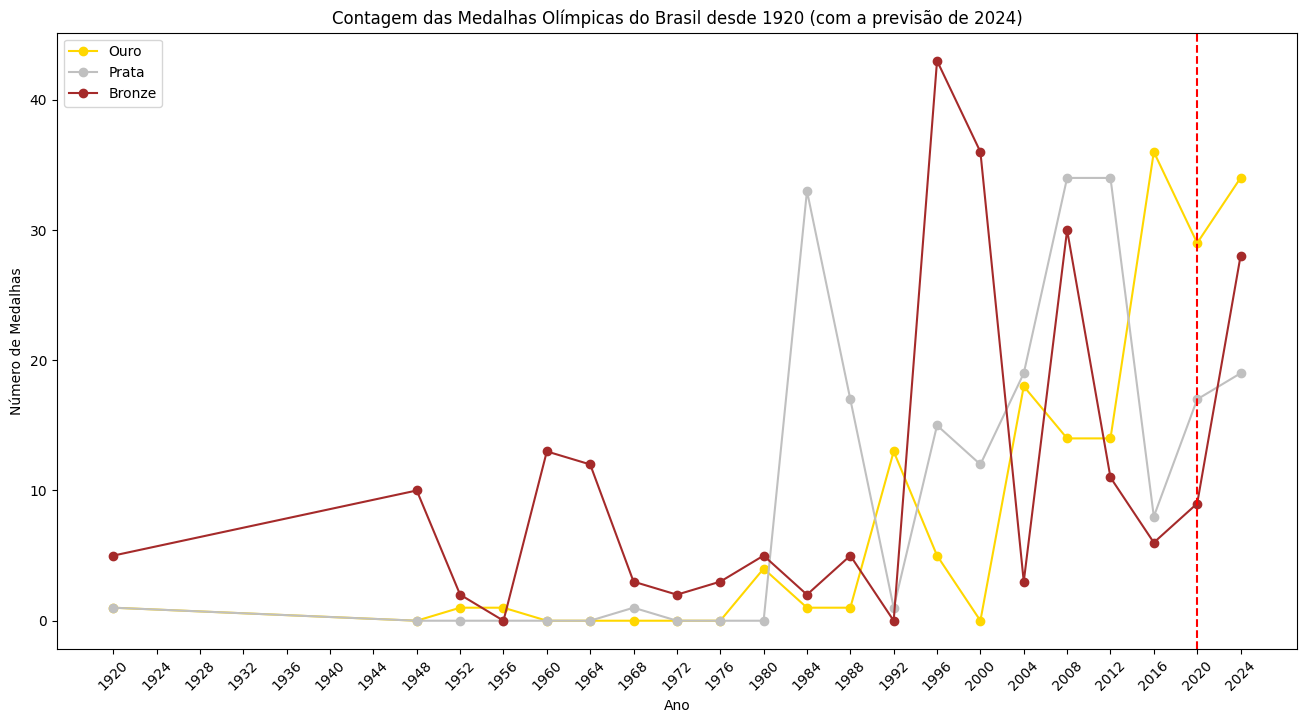

In [26]:
#plotando o gráfico das medalhas com a previsão de 2024
plt.figure(figsize=(16, 8))

#plotando cada linha
plt.plot(df_predictedBRA['Gold'], label='Gold', color='gold', marker='o')
plt.plot(df_predictedBRA['Silver'], label='Silver', color='silver', marker='o')
plt.plot(df_predictedBRA['Bronze'], label='Bronze', color='brown', marker='o')

#labels e títulos
plt.title('Contagem das Medalhas Olímpicas do Brasil desde 1920 (com a previsão de 2024)')
plt.xlabel('Ano')
plt.ylabel('Número de Medalhas')
plt.legend(['Ouro', 'Prata', 'Bronze'])

#ticks
plt.xticks(range(1920, 2025, 4))
plt.tick_params(axis='x', rotation=45)

#linha vertical
plt.axvline(x=2020, color='red', linestyle='--')

plt.show()

In [27]:
#utilizando LSTM para prever a quantidade de medalhas da China (CHN) com base na quantidade de atletas e nas medalhas dos anos anteriores

#normalizando os dados
df_trainCHN_values = df_medalsCHN[['Gold', 'Silver', 'Bronze', 'Athlete Count']].values
df_trainCHN_scaled = scaler.fit_transform(df_trainCHN_values)

#treinando 70%:
train_sizeCHN = int(len(df_trainCHN_scaled) * 0.7)
test_sizeCHN = len(df_trainCHN_scaled) - train_sizeCHN

trainCHN, testCHN = df_trainCHN_scaled[0:train_sizeCHN, :], df_trainCHN_scaled[train_sizeCHN:len(df_trainCHN_scaled), :]

trainXCHN, trainYCHN = create_dataset(trainCHN, look_back)
testXCHN, testYCHN = create_dataset(testCHN, look_back)

trainXCHN = np.reshape(trainXCHN, (trainXCHN.shape[0], trainXCHN.shape[1], trainXCHN.shape[2]))
testXCHN = np.reshape(testXCHN, (testXCHN.shape[0], testXCHN.shape[1], testXCHN.shape[2]))

#definindo o modelo
modelCHN = Sequential()
modelCHN.add(LSTM(450, input_shape=(trainXCHN.shape[1], trainXCHN.shape[2])))
modelCHN.add(Dense(trainYCHN.shape[1]))

#compilando o modelo
modelCHN.compile(loss='mean_squared_error', optimizer='adam')

#fit
modelCHN.fit(trainXCHN, trainYCHN, epochs=75, batch_size=30, verbose=0)

#prevendo
trainPredictCHN = modelCHN.predict(trainXCHN)
testPredictCHN = modelCHN.predict(testXCHN)

#denormalizando
trainPredictCHN = np.clip(scaler.inverse_transform(trainPredictCHN), 0, None)
trainYCHN = np.clip(scaler.inverse_transform(trainYCHN), 0, None)
testPredictCHN = np.clip(scaler.inverse_transform(testPredictCHN), 0, None)
testYCHN = np.clip(scaler.inverse_transform(testYCHN), 0, None)

#calculando o RMSE
trainScoreCHN = np.sqrt(mean_squared_error(trainYCHN, trainPredictCHN))
print('Train Score: %.2f RMSE' % (trainScoreCHN))
testScoreCHN = np.sqrt(mean_squared_error(testYCHN, testPredictCHN))
print('Test Score: %.2f RMSE' % (testScoreCHN))

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Train Score: 15.10 RMSE
Test Score: 13.12 RMSE


In [28]:
#shift dos valores para plotar
trainPredictPlotCHN = np.empty_like(df_trainCHN_scaled)
trainPredictPlotCHN[:, :] = np.nan
trainPredictPlotCHN[look_back:len(trainPredictCHN) + look_back, :] = trainPredictCHN

testPredictPlotCHN = np.empty_like(df_trainCHN_scaled)
testPredictPlotCHN[:, :] = np.nan
testPredictPlotCHN[len(trainPredictCHN) + (look_back * 2) + 1:len(df_trainCHN_scaled) - 1, :] = testPredictCHN

trainPredictPlotCHN = trainPredictPlotCHN[:, :-1]
testPredictPlotCHN = testPredictPlotCHN[:, :-1]

#cria um novo dataframe com os dados previstos
df_predictedCHN = df_medalsCHN.copy()

#removendo a coluna de atletas
df_predictedCHN = df_predictedCHN.drop('Athlete Count', axis=1)

#transformando Year em index
df_predictedCHN.set_index('Year', inplace=True)

#transforma trainPredictPlot num dataset
trainPredictPlot_dfCHN = pd.DataFrame(trainPredictPlotCHN)

#renomeando as colunas
trainPredictPlot_dfCHN.columns = ['Gold', 'Silver', 'Bronze']

#adicionando os anos
trainPredictPlot_dfCHN['Year'] = df_medalsCHN['Year']

#transformando Year em index
trainPredictPlot_dfCHN.set_index('Year', inplace=True)

#transforma testPredictPlot num dataset
testPredictPlot_dfCHN = pd.DataFrame(testPredictPlotCHN)

#renomeando as colunas
testPredictPlot_dfCHN.columns = ['Gold', 'Silver', 'Bronze']

#adicionando os anos
testPredictPlot_dfCHN['Year'] = df_medalsCHN['Year']

#transformando Year em index
testPredictPlot_dfCHN.set_index('Year', inplace=True)

#shiftando os valores para plotar
trainPredictPlot_dfCHN = trainPredictPlot_dfCHN.shift(-1)
testPredictPlot_dfCHN = testPredictPlot_dfCHN.shift(-1)

#removendo todos os valores nulos
testPredictPlot_dfCHN = testPredictPlot_dfCHN.dropna()
trainPredictPlot_dfCHN = trainPredictPlot_dfCHN.dropna()

#arredondando todos os valores para cima
testPredictPlot_dfCHN = testPredictPlot_dfCHN.apply(np.ceil)
trainPredictPlot_dfCHN = trainPredictPlot_dfCHN.apply(np.ceil)

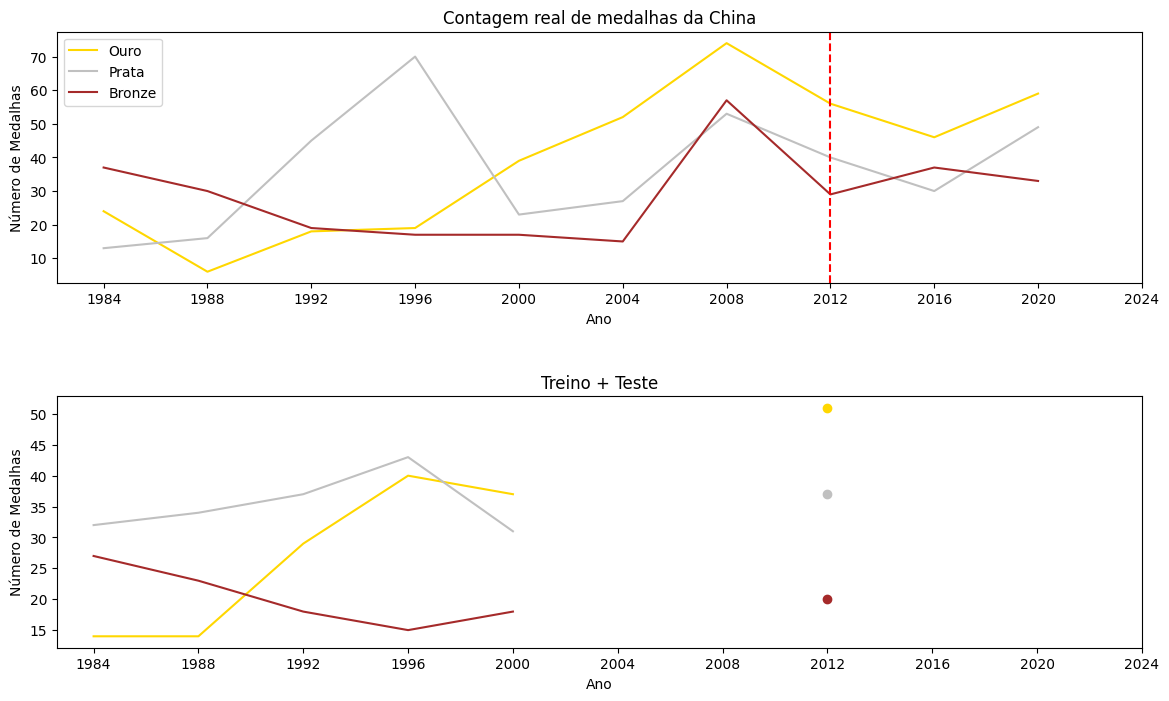

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

df_trainCHNp = df_medalsCHN.copy()

#removendo a coluna de atletas
df_trainCHNp = df_trainCHNp.drop('Athlete Count', axis=1)

#transformando Year em index
df_trainCHNp.set_index('Year', inplace=True)

#plot dos dados originais
ax1.plot(df_trainCHNp['Gold'], color='gold')
ax1.plot(df_trainCHNp['Silver'], color='silver')
ax1.plot(df_trainCHNp['Bronze'], color='brown')
ax1.set_title('Contagem real de medalhas da China')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Medalhas')
ax1.legend(['Ouro', 'Prata', 'Bronze'])
ax1.set_xticks(range(1984, 2025, 4))
ax1.axvline(x=2012, color='red', linestyle='--')

#plot treino e teste
ax2.plot(trainPredictPlot_dfCHN['Gold'], color='gold')
ax2.plot(trainPredictPlot_dfCHN['Silver'], color='silver')
ax2.plot(trainPredictPlot_dfCHN['Bronze'], color='brown')
ax2.scatter(testPredictPlot_dfCHN.index, testPredictPlot_dfCHN['Gold'], color='gold')
ax2.scatter(testPredictPlot_dfCHN.index, testPredictPlot_dfCHN['Silver'], color='silver')
ax2.scatter(testPredictPlot_dfCHN.index, testPredictPlot_dfCHN['Bronze'], color='brown')
ax2.set_title('Treino + Teste')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Medalhas')
ax2.set_xticks(range(1984, 2025, 4))

plt.subplots_adjust(hspace=0.45)

plt.show()

In [30]:
#cria um array para armazenar as previsões futuras
future_predictionsCHN = []

#pega a última sequência
last_sequenceCHN = testXCHN[-1]

#reshape da última sequência
last_sequenceCHN = np.reshape(last_sequenceCHN, (1, last_sequenceCHN.shape[0], last_sequenceCHN.shape[1]))

#gera as previsões futuras
for _ in range(num_predictions):
    next_predictionCHN = model.predict(last_sequenceCHN, verbose=0)
    
    future_predictionsCHN.append(next_predictionCHN[0])
    
    #atualiza a última sequência
    last_sequenceCHN = np.append(last_sequenceCHN[:, :, :], [[next_predictionCHN[0]]], axis=1)

#denormalize
future_predictionsCHN = scaler.inverse_transform(future_predictionsCHN)

future_predictionsCHN = future_predictionsCHN[:, :-1]

print("Future Predictions:")
for i, prediction in enumerate(future_predictionsCHN):
    print(f"Prediction {i+1}: {prediction}")

Future Predictions:
Prediction 1: [34.2815237  27.03690846 27.32783514]
Prediction 2: [50.54265285 35.26794547 34.44437152]
Prediction 3: [70.13504601 44.45641607 42.50938296]


In [31]:
#adicionando a previsão de 2024 no df
future_predictions_dfCHN = pd.DataFrame(future_predictionsCHN[2:], columns=['Gold', 'Silver', 'Bronze'], index=ano_futuro[2:])
df_predictedCHN = pd.concat([df_predictedCHN, future_predictions_dfCHN])

#remove indices duplicados
df_predictedCHN = df_predictedCHN[~df_predictedCHN.index.duplicated(keep='last')]
df_predictedCHN = df_predictedCHN.apply(np.ceil).astype(int)

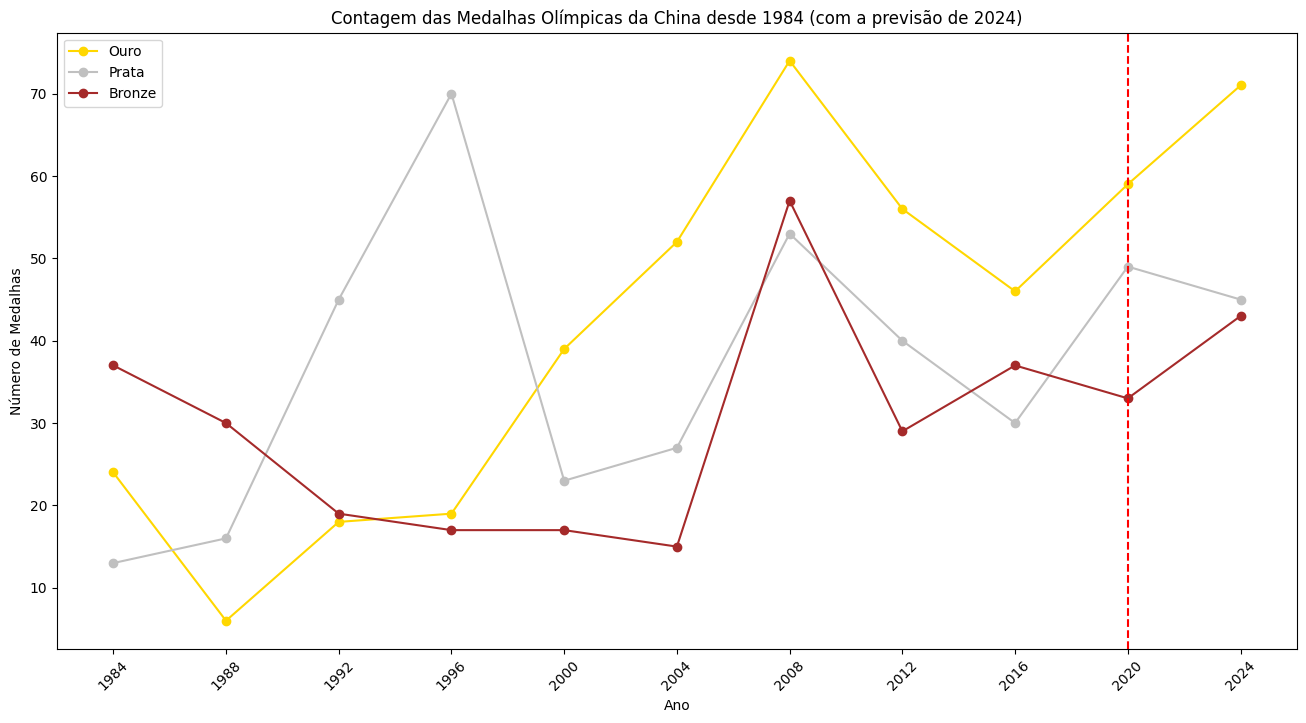

In [32]:
#plotando o gráfico das medalhas com a previsão de 2024
plt.figure(figsize=(16, 8))

#plotando cada linha
plt.plot(df_predictedCHN['Gold'], label='Gold', color='gold', marker='o')
plt.plot(df_predictedCHN['Silver'], label='Silver', color='silver', marker='o')
plt.plot(df_predictedCHN['Bronze'], label='Bronze', color='brown', marker='o')

#labels e títulos
plt.title('Contagem das Medalhas Olímpicas da China desde 1984 (com a previsão de 2024)')
plt.xlabel('Ano')
plt.ylabel('Número de Medalhas')
plt.legend(['Ouro', 'Prata', 'Bronze'])

#ticks
plt.xticks(range(1984, 2025, 4))
plt.tick_params(axis='x', rotation=45)

#linha vertical
plt.axvline(x=2020, color='red', linestyle='--')

plt.show()

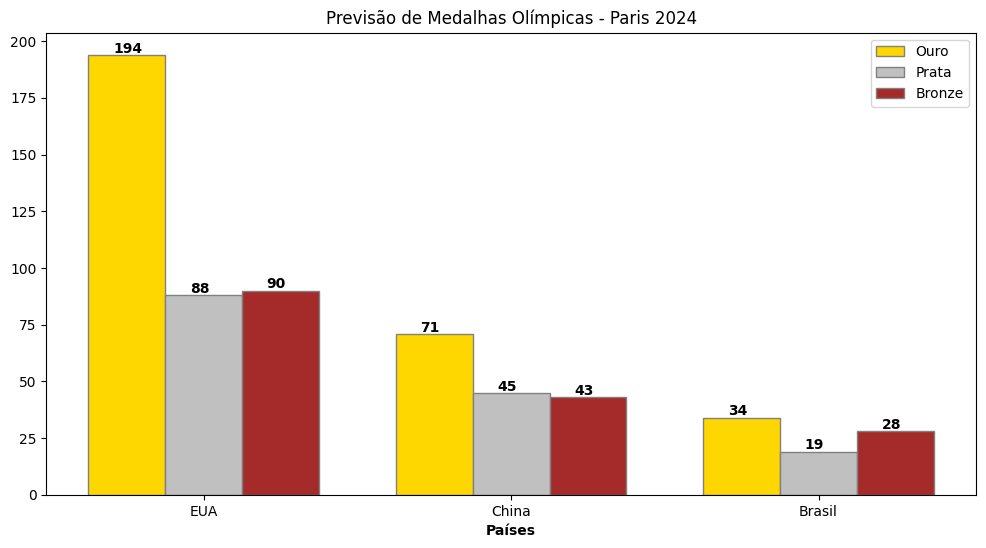

In [46]:
#gráfico de barras com as medalhas de cada país para 2024
USA_medals_2024 = df_predictedUSA.loc[2024]
BRA_medals_2024 = df_predictedBRA.loc[2024]
CHN_medals_2024 = df_predictedCHN.loc[2024]

fig, ax = plt.subplots(figsize=(12, 6))

barWidth = 0.25

bars1 = [USA_medals_2024['Gold'], CHN_medals_2024['Gold'], BRA_medals_2024['Gold']]
bars2 = [USA_medals_2024['Silver'], CHN_medals_2024['Silver'], BRA_medals_2024['Silver']]
bars3 = [USA_medals_2024['Bronze'], CHN_medals_2024['Bronze'], BRA_medals_2024['Bronze']]
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bars1, color='gold', width=barWidth, edgecolor='grey', label='Gold')
plt.bar(r2, bars2, color='silver', width=barWidth, edgecolor='grey', label='Silver')
plt.bar(r3, bars3, color='brown', width=barWidth, edgecolor='grey', label='Bronze')

plt.xlabel('Países', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['EUA', 'China', 'Brasil'])
plt.title('Previsão de Medalhas Olímpicas - Paris 2024')
plt.legend(['Ouro', 'Prata', 'Bronze'])

# Display total medals on the graph
for i, v in enumerate(bars1):
    plt.text(i - 0.045, v + 1, str(v), color='black', fontweight='bold')
for i, v in enumerate(bars2):
    plt.text(i + barWidth - 0.045, v + 1, str(v), color='black', fontweight='bold')
for i, v in enumerate(bars3):
    plt.text(i + 2*barWidth - 0.045, v + 1, str(v), color='black', fontweight='bold')

plt.show()